In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from IPython.display import Audio, display
import os
import pandas as pd
import re
import os
# import opensmile
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torchaudio
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pickle
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import re
import random
import librosa
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from IPython.display import Audio, display

In [ ]:
!unzip '/content/drive/MyDrive/IITB_EE/CS772_project/IEMOCAP.zip'
# Change directory to the root folder
os.chdir('/content/IEMOCAP')
# List the contents of the root folder
!ls

Streaming output truncated to the last 5000 lines.
  inflating: IEMOCAP/Session5/sentences/ForcedAlignment/Ses05M_impro07/Ses05M_impro07_F016.stseg  
  inflating: IEMOCAP/Session5/sentences/ForcedAlignment/Ses05M_impro07/Ses05M_impro07_F016.syseg  
  inflating: IEMOCAP/Session5/sentences/ForcedAlignment/Ses05M_impro07/Ses05M_impro07_F016.wdseg  
  inflating: IEMOCAP/Session5/sentences/ForcedAlignment/Ses05M_impro07/Ses05M_impro07_F017.phseg  
  inflating: IEMOCAP/Session5/sentences/ForcedAlignment/Ses05M_impro07/Ses05M_impro07_F017.stseg  
  inflating: IEMOCAP/Session5/sentences/ForcedAlignment/Ses05M_impro07/Ses05M_impro07_F017.syseg  
  inflating: IEMOCAP/Session5/sentences/ForcedAlignment/Ses05M_impro07/Ses05M_impro07_F017.wdseg  
  inflating: IEMOCAP/Session5/sentences/ForcedAlignment/Ses05M_impro07/Ses05M_impro07_F018.phseg  
  inflating: IEMOCAP/Session5/sentences/ForcedAlignment/Ses05M_impro07/Ses05M_impro07_F018.stseg  
  inflating: IEMOCAP/Session5/sentences/ForcedAlignment/Se

In [ ]:
#----------change the location accorgingly to you pickel file location--------------------------------
main_dir = '/content/drive/MyDrive/IITB_EE/CS772_project/'
data_pickel_path = main_dir + 'data_processed.pickle'

# Output Analysis

In [ ]:
main_dir

'/content/drive/MyDrive/IITB_EE/CS772_project/'

In [ ]:
analysis_data = pd.read_pickle(main_dir + 'analysis_data.pkl')
# analysis_data = analysis_data.rename(columns={'ll_attention_l_values': 'z_values', 'll_attention_a_values': 'll_attention_l_values', 'z_values': 'll_attention_a_values'})

In [ ]:
idx = 0
print("Sample Index",analysis_data['sample_indices'][idx])
print("Predicted Label:",analysis_data['predicted_labels_cat'][idx])
print("True Label:",analysis_data['true_labels_cat'][idx])
print("trans_words:",analysis_data['trans_words'][idx])
print(analysis_data['start_stamps'][idx])
print("Prediction Probablities:",analysis_data['predicted_probs'][idx])
# print(analysis_data['z_values'][idx].T)
print(analysis_data['z_values'][idx].T.shape)
# print(analysis_data['ll_attention_a_values'][idx])
print(analysis_data['ll_attention_a_values'][idx].shape)

Sample Index 0
Predicted Label: neu
True Label: neu
trans_words: <s> FINE <sil> </s>
0 60 94 168
Prediction Probablities: [0.01608871 0.10981538 0.85754514 0.01655074]
[0.8664549  0.2640734  0.58970714 0.29916894 0.78941345 0.51789397
 0.17456686 0.4244782  0.7624536  0.23869702 0.32578614 0.6344837
 0.1670465  0.55945116 0.46832588 0.17358272 0.26156944 0.25298795
 0.6122839  0.28500775 0.6996479  0.38036114 0.10188732 0.20127551
 0.5184984  0.66979176 0.2861037  0.12228692 0.35389936 0.26178035
 0.87689835 0.8576819  0.4391762  0.39885962 0.14418152 0.33821657
 0.7797914  0.1476391  0.28623816 0.2432679  0.5183466  0.14882965
 0.8131583  0.89479727 0.650998   0.21332392 0.11162227 0.30097213
 0.1398515  0.8755261  0.80882204 0.552282   0.18078889 0.3430722
 0.32672054 0.14719288 0.4583046  0.5243996  0.56882966 0.3790539
 0.5549409  0.12965362 0.5409308  0.8541399  0.5536197  0.20189935
 0.2722979  0.26977608 0.37840632 0.8893665  0.49870494 0.82922167
 0.8086679  0.5262817  0.223673

### Visualization

### The modality attention analysis

In [ ]:
analysis_data.columns

Index(['sample_indices', 'predicted_labels_cat', 'true_labels_cat',
       'predicted_probs', 'll_attention_a_values', 'll_attention_l_values',
       'z_values', 'audio_paths', 'trans_words', 'start_stamps', 'seq_len_l',
       'seq_len_a'],
      dtype='object')

In [ ]:
def plot_attention_values(att_acoustic, att_lexical):
    # Create a bar plot
    values = [att_acoustic, att_lexical]
    labels = ['A', 'L']
    colors = ['blue', 'orange']

    # Set the figure size
    plt.figure(figsize=(1, 1.5))

    # Plot the bar chart
    plt.bar(labels, values, color=colors, width=0.75, align='center')
    plt.title('Attention Values')
    plt.ylabel('Attention')

    # Display the plot
    plt.show()

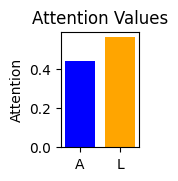

In [ ]:
idx = 0
att_acoustic = np.mean(analysis_data['z_values'][idx].T)
att_lexical = 1 - att_acoustic
plot_attention_values(att_acoustic, att_lexical)

In [ ]:
print(analysis_data['z_values'][idx].T.shape)
print(np.mean(analysis_data['z_values'][idx].T))

(128,)
0.45218852


In [ ]:
# !pip install transformers
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.2/224.2 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 38.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# from transformers import BertTokenizer, BertModel
import contractions

In [ ]:
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# # bert_model = BertModel.from_pretrained('bert-base-uncased')
# tokenizer.add_special_tokens({'additional_special_tokens': ['<sil>', '++laughter++', '++breathing++']}) # Modify the tokenizer to add special tokens
# # bert_model.resize_token_embeddings(len(tokenizer))  # Update the BERT model to account for the new tokens

In [ ]:
#  remove the <s>, </s>  tokens from the text before tokenizing 
def preprocess_text(text,):#tokenizer):
    text = text.lower()
    text = contractions.fix(text)  # Expand contractions

    # note: since we have lowered the case, we are using garbage instead of GARBAGE 
    text = text.replace('<s>', '[CLS]').replace('</s>', '[SEP]').replace('++garbage++', '') #.replace('++breathing++', '').replace('++laughter++', '').replace('<sil>', '')
    # print(text)
    # tokens = tokenizer.tokenize(text)
    # print(tokens)
    # input_ids = tokenizer.convert_tokens_to_ids(tokens)
    return text # input_ids


### The Acoustic level context based attention

goood examples:
1. 7(H,C), 400 (A,C), 24 (A,N->A), 

In [ ]:
def plot_prediction_probabilities(probabilities):
    # Create a bar plot
    labels = ['A', 'H/E', 'N', 'S']
    colors = ['red', 'orange', 'grey', 'cyan']
    plt.figure(figsize=(1.5, 1.5))
    plt.bar(labels, probabilities, color=colors)
    plt.title('Pred Prob')
    plt.ylabel('Probability')

    # Display the plot
    plt.show()

In [ ]:
import librosa
import matplotlib.pyplot as plt
import numpy as np

def visualize_attention_weights_graph(audio_idx, audio_paths, attention_weights, trans_words, start_stamps):
    audio_file_path = audio_paths[audio_idx]
    audio, sr = librosa.load(audio_file_path, sr=8000)
    num_samples = len(audio)
    duration = num_samples/sr
    t = np.linspace(0, duration, num_samples)

    # Oversample attention weights to match the number of audio samples
    x_original = np.linspace(0, len(attention_weights) - 1, len(attention_weights))
    x_oversampled = np.linspace(0, len(attention_weights) - 1, num_samples)
    oversampled_attention_weights = np.interp(x_oversampled, x_original, attention_weights)

    trans_word = trans_words[audio_idx].split()
    start_stamp_str = start_stamps[audio_idx] 
    start_stamp = (np.array(list(map(int, start_stamp_str.split())))+2)/100 # in terms of seconds
    start_stamp_samp_num = start_stamp*sr 

    fig, ax = plt.subplots(figsize=(18, 3))
    ax.plot(t, oversampled_attention_weights)
    ax.set_xlim(0, np.max(t))
    ax.set_ylim(0, np.max(oversampled_attention_weights))
    ax.set_xlabel("Time (sec))")
    ax.set_ylabel("Attention weight")
    ax.set_title("Acoustic Attention Weights")

    # Create a color map for the words
    cmap = plt.cm.get_cmap('Dark2')
    num_words = len(trans_word)
    colors = [cmap(i) for i in range(num_words)]

    # Plot the words and color their regions
    for idx, word in enumerate(trans_word):
        start_idx = int(start_stamp_samp_num[idx])
        end_idx = int(start_stamp_samp_num[idx+1]) if idx < num_words-1 else num_samples-1
        start_time = start_stamp[idx]
        end_time = start_stamp[idx+1] if idx < num_words-1 else duration
        ax.annotate(word, (start_time, oversampled_attention_weights[start_idx]), fontsize=12, color=colors[idx],rotation='vertical',va='bottom')
        ax.axvline(start_time, linestyle='--', color='red', alpha=0.7)
        ax.fill_between(t[start_idx:end_idx+1], 0, oversampled_attention_weights[start_idx:end_idx+1], color=colors[idx], alpha=0.4)
        # ax.text(start_time + pad, 0.5, word, fontsize=fontsize, color='blue', va='center', rotation='vertical')

    plt.show()


In [ ]:
import librosa
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def visualize_attention_weights_grayscale(audio_idx, audio_paths, attention_weights, trans_words, start_stamps, sr=8000):
    audio_file_path = audio_paths[audio_idx]
    audio, sr = librosa.load(audio_file_path, sr=sr)
    num_samples = len(audio)
    duration = num_samples / sr
    t = np.linspace(0, duration, num_samples)

    # Oversample attention weights to match the number of audio samples
    x_original = np.linspace(0, len(attention_weights) - 1, len(attention_weights))
    x_oversampled = np.linspace(0, len(attention_weights) - 1, num_samples)
    oversampled_attention_weights = np.interp(x_oversampled, x_original, attention_weights)

    trans_word = trans_words[audio_idx].split()
    start_stamp_str = start_stamps[audio_idx]
    start_stamp = (np.array(list(map(int, start_stamp_str.split()))) + 2) / 100  # in terms of seconds
    start_stamp_samp_num = start_stamp * sr

    # Calculate fontsize based on audio duration and transcript length
    fontsize = 10 #int(12 * duration / len(trans_word))

    fig, ax = plt.subplots(figsize=(18, 2))
    cmap = mcolors.LinearSegmentedColormap.from_list('gray', [(0, 'white'), (1, 'gray')])  # use a grayscale colormap
    im = ax.imshow([oversampled_attention_weights], cmap=cmap, aspect='auto', extent=[0, duration, 0, 1])
    ax.set_xlabel("Time (sec))")
    ax.set_ylabel("Attention weight")
    ax.set_title("Acoustic Attention Weights")
    ax.set_ylim(0, 1)

    # Add colorbar to show attention weight scale
    cbar = ax.figure.colorbar(im, ax=ax, orientation='horizontal', aspect=50)
    cbar.ax.set_xlabel('Attention weight', fontsize=fontsize)

    for idx, word in enumerate(trans_word):
        start_idx = int(start_stamp_samp_num[idx])
        start_time = start_stamp[idx]
        pad = 0.05 * duration / len(trans_word)  # add 5% padding around start time

        # Add dotted vertical line for the beginning of a new word
        ax.axvline(start_time, linestyle='--', color='red', alpha=0.7)

        ax.text(start_time + pad, 0.5, word, fontsize=fontsize, color='blue', va='center', rotation='vertical')

    plt.show()


In [ ]:
def word_attention_visualization(words, attention_weights):
    # Create a numpy array of the attention weights
    data = np.array(attention_weights)

    # Reshape the data to be a 1xN array, where N is the number of words
    data = data.reshape(1, -1)

    # Create a heatmap of the attention weights
    fig, ax = plt.subplots(figsize=(20, 2))
    im = ax.imshow(data, cmap='Reds')

    # Set the x-axis tick labels to be the words
    ax.set_xticks(np.arange(len(words)))
    ax.set_xticklabels(words, fontsize=10, rotation=45, ha='right')

    # Remove the y-axis ticks and labels
    ax.set_yticks([])
    ax.set_yticklabels([])

    # Set the colorbar
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel('Attention Weight', fontsize=12, rotation=-90, va="bottom")

    # Add a title
    ax.set_title('Attention Weights for Words', fontsize=14)

    # Display the heatmap
    plt.show()

sample index: 0, 7, 400, 2, 3, 8 (subtle laugh), 9 (acoustic attention captures the speech region,neutral and happines are close due to abiguity in the lexical modality and its high weight), 10 (sad predicted instead of hap/excited but it seems like a confusing sample if you will present to  a human as well), 11 (ambiguous if you first listen to it, neutral confused as anger),12 (can be a good question to ask what they think the label should be, a close contest but anger confused with happiness, the 'Oh' is given a lot of weight) 

1.  Our model might have overfitted to the lexical modality because of the higher complexity of the lexical model.

In [ ]:
audio_idx = 400

Predicted Label: neu
True Label: neu
trans_words: <s> <sil> HE'S LIKE A MANAGER FOR A THEATRE </s>
cat:                         angery | happy/excited | neutral | sad
Prediction probablities: [0.31784546 0.04124825 0.5903537  0.05055256]


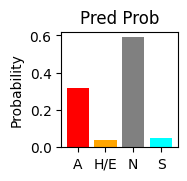

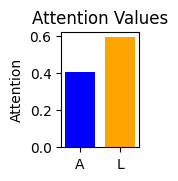

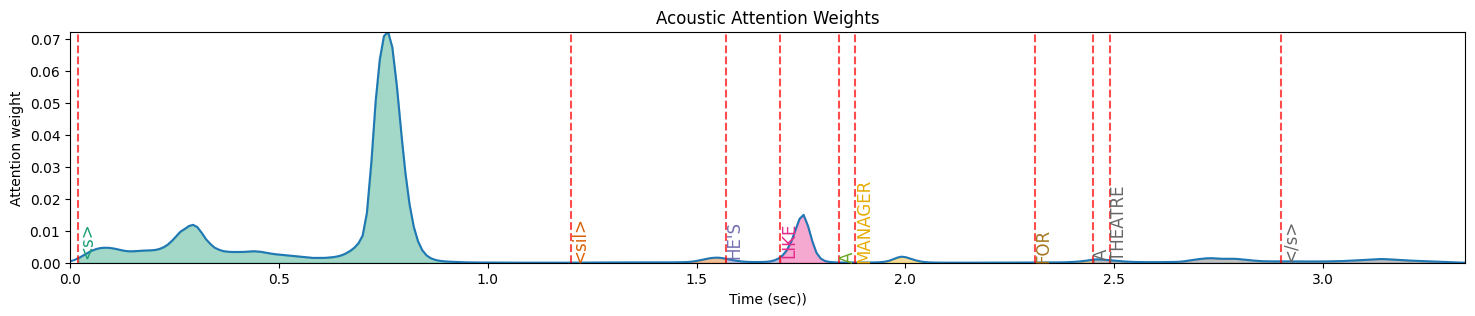

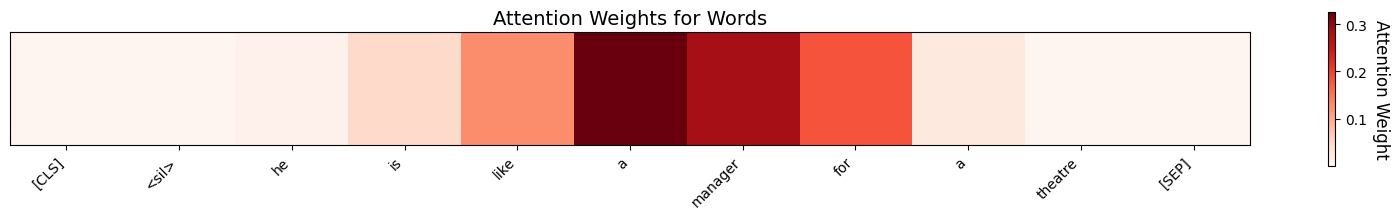

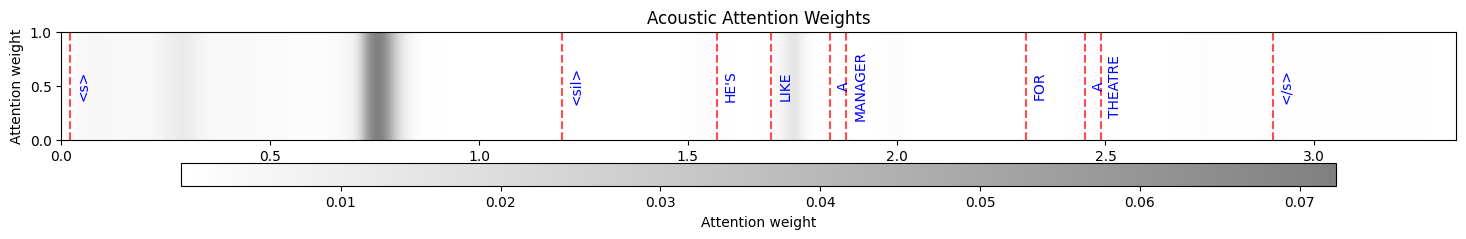

In [ ]:
audio_idx = 15

# Play the audio file
print("Predicted Label:",analysis_data['predicted_labels_cat'][audio_idx])
print("True Label:",analysis_data['true_labels_cat'][audio_idx])
print("trans_words:",analysis_data['trans_words'][audio_idx])
print("cat:                         angery | happy/excited | neutral | sad")
print("Prediction probablities:",analysis_data['predicted_probs'][audio_idx])
audio_file_path = analysis_data['audio_paths'][audio_idx]
display(Audio(audio_file_path))
plot_prediction_probabilities(analysis_data['predicted_probs'][audio_idx])
att_acoustic = np.mean(analysis_data['z_values'][audio_idx].T)
att_lexical = 1 - att_acoustic
plot_attention_values(att_acoustic, att_lexical)
attention_weights = analysis_data['ll_attention_a_values'][audio_idx]
visualize_attention_weights_graph(audio_idx,analysis_data['audio_paths'], attention_weights, 
                            analysis_data['trans_words'], analysis_data['start_stamps'])
process_trans = preprocess_text(analysis_data['trans_words'][audio_idx]).split()
# print(len(process_trans),process_trans)
word_attention_weights = analysis_data['ll_attention_l_values'][audio_idx]
# print(len(word_attention_weights),word_attention_weights)
word_attention_visualization(process_trans, word_attention_weights)
visualize_attention_weights_grayscale(audio_idx,analysis_data['audio_paths'], attention_weights, 
                            analysis_data['trans_words'], analysis_data['start_stamps'])

### **Creating the video for visualization**

In [ ]:
!pip install moviepy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from moviepy.video.io.bindings import mplfig_to_npimage

def make_frame(idx, attention_weights):
    fig, ax = plt.subplots()
    ax.plot(attention_weights[:idx], 'ro')
    ax.set_xlim(0, len(attention_weights))
    ax.set_ylim(0, np.max(attention_weights))
    ax.set_xlabel("Time steps")
    ax.set_ylabel("Attention weight")
    ax.set_title("Acoustic Attention Weights")
    
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    
    plt.close(fig)
    return image


from moviepy.editor import AudioFileClip, VideoClip

from moviepy.editor import VideoClip, AudioFileClip
import numpy as np


def create_attention_video(audio_file_path, attention_weights, fps=30, output_file="output.mp4"):
    audio = AudioFileClip(audio_file_path)
    duration = audio.duration

    # Calculate the number of frames
    num_frames = int(duration * fps)

    # Oversample attention weights to match the number of frames
    x_original = np.linspace(0, len(attention_weights) - 1, len(attention_weights))
    x_oversampled = np.linspace(0, len(attention_weights) - 1, num_frames)
    oversampled_attention_weights = np.interp(x_oversampled, x_original, attention_weights)

    # Create the video clip from the attention weights
    video = VideoClip(lambda x: make_frame(int(x * fps), oversampled_attention_weights), duration=duration)

    # Set the audio of the video clip
    video = video.set_audio(audio)

    # Write the video to a file
    video.write_videofile(output_file, fps=fps)


In [ ]:
audio_idx = 7
audio_file_path = analysis_data['audio_paths'][audio_idx]
attention_weights = analysis_data['ll_attention_a_values'][audio_idx]

create_attention_video(audio_file_path, attention_weights, output_file="attention_video.mp4")


Moviepy - Building video attention_video.mp4.
MoviePy - Writing audio in attention_videoTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video attention_video.mp4



Moviepy - Done !
Moviepy - video ready attention_video.mp4
